In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd drive/MyDrive/Colab\ Notebooks/datasets/2022_nefticode

/content/drive/MyDrive/Colab Notebooks/datasets/2022_nefticode


In [3]:
# %pip install catboost

In [4]:
!ls

 model		  nn_rast_temp.pkl	   x_train.csv
 nn_deep_0.pkl	  nn_temp_rasm.pkl	   y_train.csv
 nn_deep_25.pkl   submission_example.csv  'Описание кейса.docx'
 nn_elast_0.pkl   x_test.csv


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0,7.0)
plt.style.use('dark_background')
import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error #для проверки\
# from sklearn.preprocessing import 
import random

In [6]:
df_ex= pd.read_csv("submission_example.csv",sep=',',error_bad_lines=False,index_col=False)
df_ex.head(1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,id,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,0,30.0,67.6,21.3,64.8,76.2


In [7]:
df_test= pd.read_csv("x_test.csv",sep=',',error_bad_lines=False,index_col=False)
df_test.head(1)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25
0,0,0.3,93.0,4.434,2.2,0.066,75,Adhesion2,Plasticizer4,Polymer2,119,75.0


In [8]:
df_test.isna().sum()

id                                                    0
% массы <Адгезионная добавка>                         0
% массы <Базовый битум>                               0
% массы <Пластификатор>                               0
% массы <Полимер>                                     0
% массы <Сшивающая добавка>                           0
Исходная игла при 25С <Базовый битум>                 0
Адгезионная добавка                                   0
Пластификатор                                         0
Полимер                                               0
Базовая пенетрация для расчёта пластификатора         0
Расчёт рецептуры на глубину проникания иглы при 25    0
dtype: int64

In [9]:
df_x= pd.read_csv("x_train.csv",sep=',',error_bad_lines=False,index_col=False)
df_x.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25
0,0,0.0,90.4,5.9,3.6,0.1,79,Отсутствует,Plasticizer1,Polymer1,138,75
1,1,0.3,90.1,5.9,3.6,0.1,79,Adhesion1,Plasticizer2,Polymer2,138,75
2,2,0.3,90.1,5.9,3.6,0.1,79,Adhesion1,Plasticizer3,Polymer2,138,75
3,3,0.3,90.1,5.9,3.6,0.1,79,Adhesion1,Plasticizer4,Polymer2,138,75
4,4,0.3,89.0,7.0,3.6,0.1,79,Adhesion1,Plasticizer4,Polymer2,138,75


In [10]:
df_y= pd.read_csv("y_train.csv",sep=',',error_bad_lines=False,index_col=False)
df_y.head(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,id,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,0,33.0,71.0,21.0,74.4,73.0
1,1,32.0,71.0,16.0,72.8,75.0
2,2,35.0,76.0,27.0,74.0,78.0
3,3,30.0,65.0,13.0,75.0,75.0
4,4,32.0,66.0,14.0,75.0,77.0


In [11]:
df_y = df_y.drop('id', axis=1)

In [12]:
df_y.isna().sum()

Глубина  проникания иглы при 0 °С, [мм-1]      3
Глубина  проникания иглы при 25 °С, [мм-1]     1
Растяжимость  при температуре 0 °С, [см]       2
Температура размягчения, [°С]                  2
Эластичность при 0 °С, [%]                    45
dtype: int64

In [13]:
df_y.shape

(108, 5)

In [14]:
# df_y = df_y.dropna(how='any')

In [15]:
# df_y= df_y.fillna(0)

In [16]:
df_y.shape

(108, 5)

In [17]:
df_y.isna().sum()

Глубина  проникания иглы при 0 °С, [мм-1]      3
Глубина  проникания иглы при 25 °С, [мм-1]     1
Растяжимость  при температуре 0 °С, [см]       2
Температура размягчения, [°С]                  2
Эластичность при 0 °С, [%]                    45
dtype: int64

#Объединение таблиц

In [18]:
df_big = pd.concat([df_x,df_y],axis=1)

In [19]:
df_big.isna().sum()

id                                                     0
% массы <Адгезионная добавка>                          0
% массы <Базовый битум>                                0
% массы <Пластификатор>                                0
% массы <Полимер>                                      0
% массы <Сшивающая добавка>                            0
Исходная игла при 25С <Базовый битум>                  0
Адгезионная добавка                                    0
Пластификатор                                          0
Полимер                                                0
Базовая пенетрация для расчёта пластификатора          0
Расчёт рецептуры на глубину проникания иглы при 25     0
Глубина  проникания иглы при 0 °С, [мм-1]              3
Глубина  проникания иглы при 25 °С, [мм-1]             1
Растяжимость  при температуре 0 °С, [см]               2
Температура размягчения, [°С]                          2
Эластичность при 0 °С, [%]                            45
dtype: int64

In [20]:
df_big.head(3)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,0,0.0,90.4,5.9,3.6,0.1,79,Отсутствует,Plasticizer1,Polymer1,138,75,33.0,71.0,21.0,74.4,73.0
1,1,0.3,90.1,5.9,3.6,0.1,79,Adhesion1,Plasticizer2,Polymer2,138,75,32.0,71.0,16.0,72.8,75.0
2,2,0.3,90.1,5.9,3.6,0.1,79,Adhesion1,Plasticizer3,Polymer2,138,75,35.0,76.0,27.0,74.0,78.0


In [21]:
df_big.describe()

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
count,108.00000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,105.000000,107.000000,106.000000,106.000000,63.000000
mean,53.50000,0.158769,90.359667,5.749704,3.634454,0.097407,76.907407,133.037037,75.324074,32.561905,75.056075,29.202830,72.911321,75.031746
std,31.32092,0.150964,1.938747,1.830692,0.195411,0.017641,7.703060,17.601469,3.367877,4.176223,11.967591,11.158831,3.548529,5.716327
min,0.00000,0.000000,78.750000,0.200000,2.200000,0.040000,63.000000,78.000000,75.000000,23.000000,52.000000,11.000000,59.000000,65.000000
25%,26.75000,0.000000,89.631500,5.000000,3.600000,0.100000,73.000000,130.000000,75.000000,31.000000,71.000000,21.000000,71.000000,71.500000
50%,53.50000,0.297500,90.050000,6.000000,3.600000,0.100000,75.000000,138.000000,75.000000,32.000000,74.000000,27.250000,73.000000,74.000000
75%,80.25000,0.300000,91.107000,6.324750,3.750000,0.108000,79.000000,138.000000,75.000000,34.000000,77.500000,35.750000,75.000000,77.000000
max,107.00000,0.350000,97.560000,17.000000,4.100000,0.121000,129.000000,245.000000,110.000000,55.000000,155.000000,67.000000,80.000000,94.000000


In [22]:
# df_big = df_big.dropna(how='any')

In [23]:
df_big.shape

(108, 17)

In [24]:
# df_big['Эластичность при 0 °С, [%]'].fillna(75.031746,inplace = True)
df_big['Эластичность при 0 °С, [%]'].fillna(random.uniform(70, 85),inplace = True)
df_big['Температура размягчения, [°С]'].fillna(random.uniform(72, 74),inplace = True)
df_big['Растяжимость  при температуре 0 °С, [см]'].fillna(random.uniform(28, 32),inplace = True)
df_big['Глубина  проникания иглы при 0 °С, [мм-1]'].fillna(random.uniform(20, 40),inplace = True)
df_big['Глубина  проникания иглы при 25 °С, [мм-1]'].fillna(random.uniform(75, 90),inplace = True)

In [25]:
df_big.isna().sum()

id                                                    0
% массы <Адгезионная добавка>                         0
% массы <Базовый битум>                               0
% массы <Пластификатор>                               0
% массы <Полимер>                                     0
% массы <Сшивающая добавка>                           0
Исходная игла при 25С <Базовый битум>                 0
Адгезионная добавка                                   0
Пластификатор                                         0
Полимер                                               0
Базовая пенетрация для расчёта пластификатора         0
Расчёт рецептуры на глубину проникания иглы при 25    0
Глубина  проникания иглы при 0 °С, [мм-1]             0
Глубина  проникания иглы при 25 °С, [мм-1]            0
Растяжимость  при температуре 0 °С, [см]              0
Температура размягчения, [°С]                         0
Эластичность при 0 °С, [%]                            0
dtype: int64

In [26]:
df_big.shape

(108, 17)

In [27]:
# df.isna().sum()

In [28]:
# df= df.fillna(0)

#Проверка корреляции

In [29]:
df_big.head(3)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,0,0.0,90.4,5.9,3.6,0.1,79,Отсутствует,Plasticizer1,Polymer1,138,75,33.0,71.0,21.0,74.4,73.0
1,1,0.3,90.1,5.9,3.6,0.1,79,Adhesion1,Plasticizer2,Polymer2,138,75,32.0,71.0,16.0,72.8,75.0
2,2,0.3,90.1,5.9,3.6,0.1,79,Adhesion1,Plasticizer3,Polymer2,138,75,35.0,76.0,27.0,74.0,78.0


In [30]:
list(df_big.columns.values)

['id',
 '% массы <Адгезионная добавка>',
 '% массы <Базовый битум>',
 '% массы <Пластификатор>',
 '% массы <Полимер>',
 '% массы <Сшивающая добавка>',
 'Исходная игла при 25С <Базовый битум>',
 'Адгезионная добавка',
 'Пластификатор',
 'Полимер',
 'Базовая пенетрация для расчёта пластификатора',
 'Расчёт рецептуры на глубину проникания иглы при 25',
 'Глубина  проникания иглы при 0 °С, [мм-1]',
 'Глубина  проникания иглы при 25 °С, [мм-1]',
 'Растяжимость  при температуре 0 °С, [см]',
 'Температура размягчения, [°С]',
 'Эластичность при 0 °С, [%]']

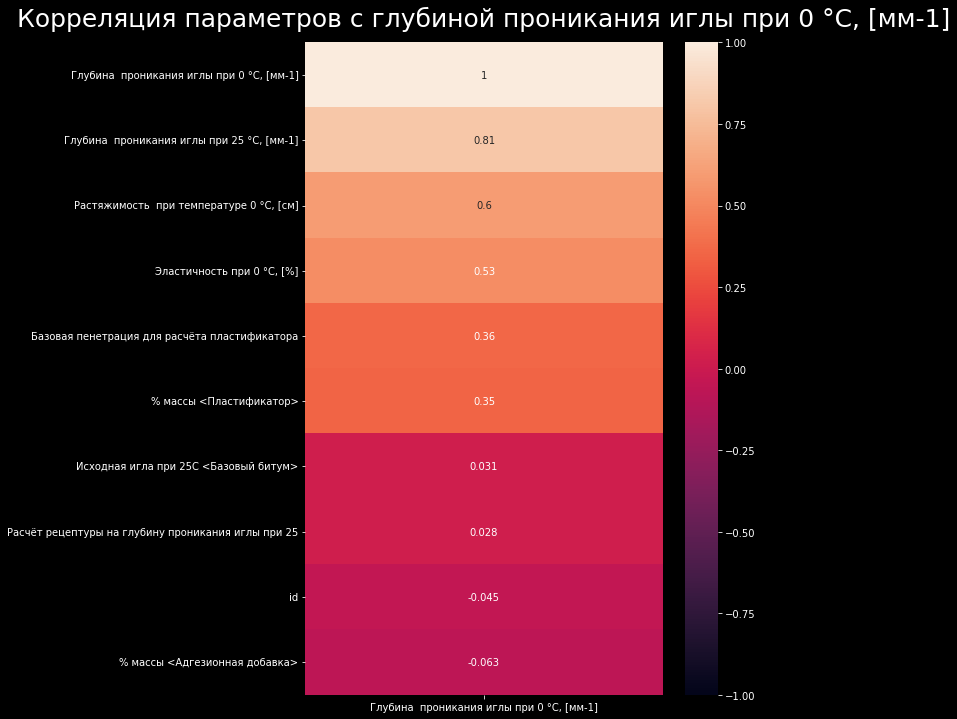

In [31]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_big.corr()[['Глубина  проникания иглы при 0 °С, [мм-1]']].sort_values(by='Глубина  проникания иглы при 0 °С, [мм-1]', ascending=False).head(10), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Корреляция параметров с глубиной проникания иглы при 0 °С, [мм-1]', fontdict={'fontsize':25}, pad=16);

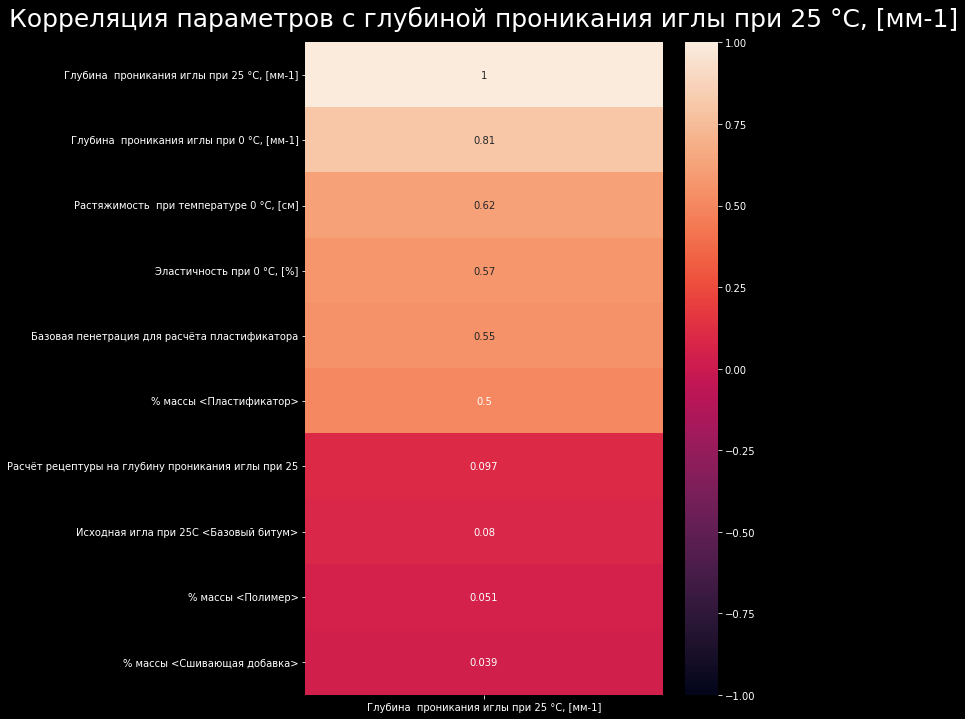

In [32]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_big.corr()[['Глубина  проникания иглы при 25 °С, [мм-1]']].sort_values(by='Глубина  проникания иглы при 25 °С, [мм-1]', ascending=False).head(10), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Корреляция параметров с глубиной проникания иглы при 25 °С, [мм-1]', fontdict={'fontsize':25}, pad=16);

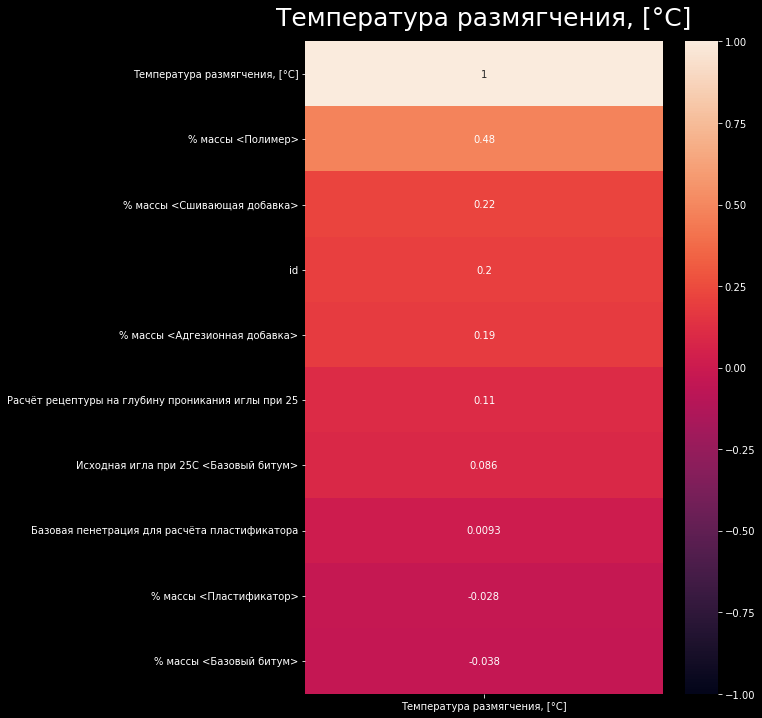

In [33]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_big.corr()[['Температура размягчения, [°С]']].sort_values(by='Температура размягчения, [°С]', ascending=False).head(10), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Температура размягчения, [°С]', fontdict={'fontsize':25}, pad=16);

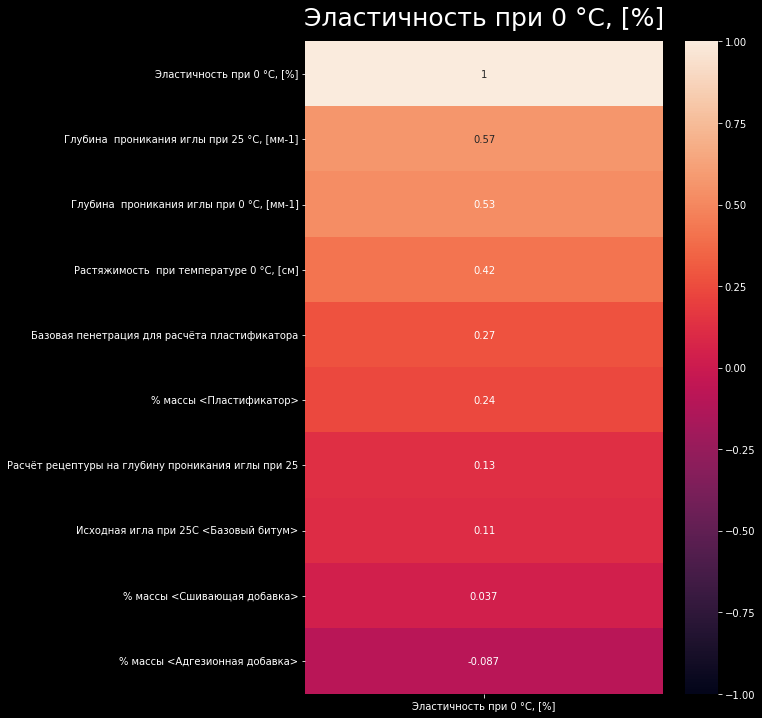

In [34]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df_big.corr()[['Эластичность при 0 °С, [%]']].sort_values(by='Эластичность при 0 °С, [%]', ascending=False).head(10), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Эластичность при 0 °С, [%]', fontdict={'fontsize':25}, pad=16);

#Переведем текстовые данные в числовые

In [35]:
encod_adg = LabelEncoder()
encod_plas = LabelEncoder()
encod_poly = LabelEncoder()

In [36]:
list_adg = encod_adg.fit_transform(df_big["Адгезионная добавка"])
list_plas = encod_plas.fit_transform(df_big["Пластификатор"])
list_poly = encod_poly.fit_transform(df_big["Полимер"])

In [37]:
df_big["Адгезионная добавка"] = list_adg 
df_big["Пластификатор"] = list_plas
df_big["Полимер"] = list_poly

In [38]:
df_big.head(3)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,0,0.0,90.4,5.9,3.6,0.1,79,4,0,0,138,75,33.0,71.0,21.0,74.4,73.0
1,1,0.3,90.1,5.9,3.6,0.1,79,0,11,1,138,75,32.0,71.0,16.0,72.8,75.0
2,2,0.3,90.1,5.9,3.6,0.1,79,0,18,1,138,75,35.0,76.0,27.0,74.0,78.0


#Используем Min_max

In [39]:
scaler = MinMaxScaler()

In [40]:
df_norm =scaler.fit_transform(df_big)

In [41]:
df_norm = pd.DataFrame(df_norm ,columns =df_big.columns )
df_norm.head(3)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,0.000000,0.000000,0.619351,0.339286,0.736842,0.740741,0.242424,1.0,0.000000,0.000000,0.359281,0.0,0.31250,0.184466,0.178571,0.733333,0.275862
1,0.009346,0.857143,0.603402,0.339286,0.736842,0.740741,0.242424,0.0,0.458333,0.333333,0.359281,0.0,0.28125,0.184466,0.089286,0.657143,0.344828
2,0.018692,0.857143,0.603402,0.339286,0.736842,0.740741,0.242424,0.0,0.750000,0.333333,0.359281,0.0,0.37500,0.233010,0.285714,0.714286,0.448276


#Модель предикта [Глубина проникания иглы при 0 °С, [мм-1]]

#model_deep

In [42]:
#подгрузим инструменты для прогнозирования 
# from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0,7.0) 
plt.style.use('dark_background')

In [43]:
X = df_norm.iloc[:,1:12].values
y = df_norm['Глубина  проникания иглы при 0 °С, [мм-1]'].values

In [44]:
X.shape

(108, 11)

Разделим на тренировочный и тестовый датасет

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [46]:
print(f"X_train рамерность {X_train.shape}")
print(f"X_test рамерность {X_test.shape}")

X_train рамерность (97, 11)
X_test рамерность (11, 11)


In [47]:
model_deep = keras.Sequential()
model_deep.add(Dense(units=1,input_shape=(11,),activation='linear'))
model_deep.compile(loss ='mean_squared_error', optimizer = keras.optimizers.Adam(0.1))

In [48]:
print(model_deep.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 12        
                                                                 
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
history = model_deep.fit(X,y,epochs=1000,verbose =0)

Text(0, 0.5, 'Средний квадрат ошибки')

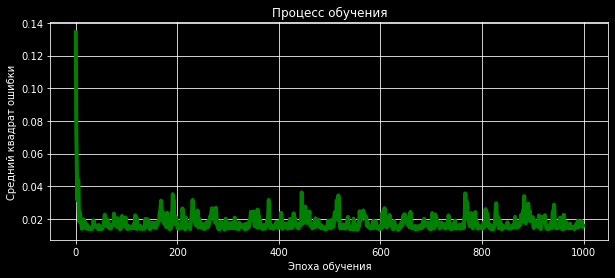

In [50]:
fig, (plot1) = plt.subplots(
    nrows=1, ncols=1,
    figsize=(10, 4)
)

plot1.plot(history.history['loss'],color = 'g',linewidth = 4)
plot1.grid(True)
plot1.set_title('Процесс обучения')
plot1.set_xlabel('Эпоха обучения')
plot1.set_ylabel('Средний квадрат ошибки')

#Прогоним по тренировочному датасету

In [51]:
from sklearn.metrics import mean_squared_error

In [52]:
y_predicted = model_deep.predict(X_test)

In [53]:
y_actual =  y_test

In [54]:
rms = mean_squared_error(y_actual, y_predicted, squared=False)

In [55]:
rms

0.1524815473066887

#Проверка метрик

In [56]:
# from sklearn.metrics import mean_squared_error

# rms = mean_squared_error(y_actual, y_predicted, squared=False)

#Попробую создать модель в pytorch

In [57]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data.dataloader as dataloader
import torch.nn.functional as F
from sklearn.metrics import balanced_accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset,random_split,Dataset

In [58]:
df_norm.head(3)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,0.000000,0.000000,0.619351,0.339286,0.736842,0.740741,0.242424,1.0,0.000000,0.000000,0.359281,0.0,0.31250,0.184466,0.178571,0.733333,0.275862
1,0.009346,0.857143,0.603402,0.339286,0.736842,0.740741,0.242424,0.0,0.458333,0.333333,0.359281,0.0,0.28125,0.184466,0.089286,0.657143,0.344828
2,0.018692,0.857143,0.603402,0.339286,0.736842,0.740741,0.242424,0.0,0.750000,0.333333,0.359281,0.0,0.37500,0.233010,0.285714,0.714286,0.448276


In [59]:
# y = df_norm.iloc[:,12:].values
# y

In [60]:
y = df_norm.iloc[:,12].values
y

array([0.3125    , 0.28125   , 0.375     , 0.21875   , 0.28125   ,
       0.40625   , 0.375     , 0.        , 0.3125    , 0.25      ,
       0.09375   , 0.09375   , 0.34375   , 0.09375   , 0.15625   ,
       0.34375   , 0.78125   , 0.28125   , 0.71875   , 0.21875   ,
       0.09375   , 0.28125   , 0.28125   , 0.375     , 0.3125    ,
       0.21875   , 0.28125   , 0.53125   , 0.46875   , 0.28125   ,
       0.28125   , 0.28125   , 0.34375   , 0.46875   , 0.46875   ,
       0.        , 0.0625    , 1.        , 0.34375   , 0.21875   ,
       0.51955563, 0.09375   , 0.21875   , 0.34375   , 0.375     ,
       0.40625   , 0.21875   , 0.28125   , 0.3125    , 0.34375   ,
       0.3125    , 0.3125    , 0.28125   , 0.28125   , 0.34375   ,
       0.28125   , 0.28125   , 0.3125    , 0.28125   , 0.28125   ,
       0.28125   , 0.3125    , 0.34375   , 0.28125   , 0.28125   ,
       0.28125   , 0.3125    , 0.51955563, 0.28125   , 0.375     ,
       0.51955563, 0.53125   , 0.28125   , 0.34375   , 0.25   

In [61]:
X = df_norm.iloc[:,1:12].values
X

array([[0.        , 0.61935141, 0.33928571, ..., 0.        , 0.35928144,
        0.        ],
       [0.85714286, 0.60340245, 0.33928571, ..., 0.33333333, 0.35928144,
        0.        ],
       [0.85714286, 0.60340245, 0.33928571, ..., 0.33333333, 0.35928144,
        0.        ],
       ...,
       [0.83714286, 0.65879851, 0.29797619, ..., 0.33333333, 0.1497006 ,
        0.        ],
       [0.88857143, 0.68591175, 0.22857143, ..., 0.33333333, 0.23952096,
        0.        ],
       [0.        , 0.64327485, 0.31553571, ..., 0.33333333, 0.34131737,
        0.        ]])

Сравнение train и test

In [62]:
df_norm.iloc[:,1:12].head(1)

,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25
0,0.0,0.619351,0.339286,0.736842,0.740741,0.242424,1.0,0.0,0.0,0.359281,0.0


In [63]:
df_test.head(1)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25
0,0,0.3,93.0,4.434,2.2,0.066,75,Adhesion2,Plasticizer4,Polymer2,119,75.0


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [65]:
X_train_t = torch.tensor(X_train)
Y_train_t = torch.tensor(y_train) 

X_test_t = torch.tensor(X_test)
Y_test_t = torch.tensor(y_test)
train_dataset = TensorDataset(X_train_t, Y_train_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)

Гиперпараметры 

In [66]:
batch_size = 32
lr = 0.001

Создадим даталоудеры

In [67]:
train_dataloader = DataLoader(dataset =train_dataset, batch_size=20,shuffle=True)
test_dataloader = DataLoader(dataset =test_dataset, batch_size=1,shuffle=True)

In [68]:
len_columns = len(X_train)

In [69]:
# class predictNN(nn.Module):
#     def __init__(self,input_size, hidden_size1,hidden_size2,n_class):
#         super(predictNN,self).__init__()

#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, n_class)
#         self.dropout = nn.Dropout(p=0.1)
#         self.batchnorm1 = nn.BatchNorm1d(hidden_size1)
#         self.batchnorm2 = nn.BatchNorm1d(hidden_size2)
        
#     def forward(self, inputs):
#         x = F.relu(self.fc1(inputs))
#         # x = self.batchnorm1(x)
#         x = F.relu(self.fc2(x))
#         # x = self.batchnorm2(x)
#         x = self.dropout(x)
#         x = self.fc3(x)

#         return x

In [70]:
# print(X.shape[1],y.shape[1])

In [71]:
class predictNN(nn.Module):
  def __init__(self,open_size,input_size1,input_size2,input_size3, n_classes):
      super(predictNN,self).__init__()
      self.fc1 = nn.Linear(open_size,input_size1)
      self.act1 = nn.Sigmoid()
      self.fc2 = nn.Linear(input_size1,input_size2)
      self.act2= nn.Sigmoid()
      self.fc3 = nn.Linear(input_size2,input_size3)
      self.act3 =nn.Sigmoid()
      self.fc4 = nn.Linear(input_size3,n_classes)
      self.dropout = nn.Dropout(p=0.2)
      self.batchnorm1 = nn.BatchNorm1d(input_size1)
      self.batchnorm2 = nn.BatchNorm1d(input_size3)
  def forward (self,x):
    x = self.fc1(x)
    x = self.batchnorm1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    x = self.act3(x)
    x = self.batchnorm2(x)
    x = self.dropout(x)
    x = self.fc4(x)
    # return F.log_softmax(x, dim=1)
    return F.relu6(x) #не плохой выбор


    # return x

In [72]:
# F.celu

In [73]:
data_shape = X.shape[1]
input_size1 = 200
input_size2 = 1000
input_size3 = 500
# n_classes = y.shape[1]
n_classes = 1
# nn_my = predictNN(data_shape,input_size1,input_size2,input_size3,n_classes).to(device)
nn_my = predictNN(data_shape,input_size1,input_size2,input_size3,n_classes)
print(nn_my)

predictNN(
  (fc1): Linear(in_features=11, out_features=200, bias=True)
  (act1): Sigmoid()
  (fc2): Linear(in_features=200, out_features=1000, bias=True)
  (act2): Sigmoid()
  (fc3): Linear(in_features=1000, out_features=500, bias=True)
  (act3): Sigmoid()
  (fc4): Linear(in_features=500, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [74]:
lr1 = 10**(-4)
print(f"learning_rate: {lr1}")
batch_size1 = 1 # good tone to used batch 
batch_size2 = 1

learning_rate: 0.0001


In [75]:
loss_function = nn.CrossEntropyLoss()
# optimizer = optim.Adam(nn_my.parameters(),lr = lr1)
optimizer = torch.optim.SGD(nn_my.parameters(), lr=lr1)
# criterion = nn.BCEWithLogitsLoss()
criterion = torch.nn.MSELoss(size_average=False) #хорошо работает
# criterion = torch.nn.BCELoss(size_average=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [76]:
epochs =5000

In [77]:
# запускаем главный тренировочный цикл
for epoch in range(epochs):
   epoch_loss = 0
   epoch_acc = 0
   for batch_idx, (data, target) in enumerate(train_dataloader):
       optimizer.zero_grad()
       net_out = nn_my(data.float())
      #  print(net_out.shape)
      #  print(net_out)
      #  print(target.shape)
       net_out = net_out.squeeze()
       
       loss = criterion(net_out.float(), target.float())
       loss.backward()
       optimizer.step()
       epoch_loss += loss.item()
       print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(train_dataloader):.5f} |')


Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch 4000: | Loss: 0.06364 |
Epoch 4000: | Loss: 0.11055 |
Epoch 4000: | Loss: 0.13304 |
Epoch 4000: | Loss: 0.15864 |
Epoch 4000: | Loss: 0.20468 |
Epoch 4001: | Loss: 0.06647 |
Epoch 4001: | Loss: 0.09108 |
Epoch 4001: | Loss: 0.12602 |
Epoch 4001: | Loss: 0.16715 |
Epoch 4001: | Loss: 0.21529 |
Epoch 4002: | Loss: 0.01840 |
Epoch 4002: | Loss: 0.09073 |
Epoch 4002: | Loss: 0.13727 |
Epoch 4002: | Loss: 0.22182 |
Epoch 4002: | Loss: 0.23876 |
Epoch 4003: | Loss: 0.07006 |
Epoch 4003: | Loss: 0.11468 |
Epoch 4003: | Loss: 0.16685 |
Epoch 4003: | Loss: 0.19525 |
Epoch 4003: | Loss: 0.21024 |
Epoch 4004: | Loss: 0.02420 |
Epoch 4004: | Loss: 0.08513 |
Epoch 4004: | Loss: 0.12816 |
Epoch 4004: | Loss: 0.17994 |
Epoch 4004: | Loss: 0.21745 |
Epoch 4005: | Loss: 0.05236 |
Epoch 4005: | Loss: 0.06106 |
Epoch 4005: | Loss: 0.18077 |
Epoch 4005: | Loss: 0.23278 |
Epoch 4005: | Loss: 0.25208 |
Epoch 4006: | Loss: 0.01821 |
Ep

In [78]:
print(f"Нейронка для столбца: {list(df_norm.columns.values)[12]}")

Нейронка для столбца: Глубина  проникания иглы при 0 °С, [мм-1]


In [79]:
# from tensorflow.python import profiler_client
y_pred_list = []
rms_middle =[]
nn_my.eval()
with torch.no_grad():
   for X_batch,y_batch in test_dataloader:
    #  X_batch = X_batch.to(device)
    #  print(X_batch)
    y_batch = y_batch.tolist()
    y_test_pred = nn_my(X_batch.float())
    y_test_pred = y_test_pred.tolist()
    print(f"То что должно быть: {y_batch} ")
    print(f"Предсказанный результат: {y_test_pred}")
    print("--"*60)

    #  print(y_test_pred)
    #  y_test_pred = torch.sigmoid(y_test_pred)
    # #  print(y_test_pred)
    #  y_pred_tag = torch.round(y_test_pred)
    #  y_pred_tag = y_pred_tag.squeeze(0)
    #  print(y_pred_tag)
    #  print((y_pred_tag.squeeze(0)).shape)
    # y_pred_list.append(y_test_pred.tolist())
    rms = mean_squared_error(y_batch, y_test_pred , squared=False)
    rms_middle.append(rms)
    print(f"rms:{rms}")
print(f"rms_middle:{sum(rms_middle)/len(rms_middle)}")

То что должно быть: [0.15625] 
Предсказанный результат: [[0.3637771010398865]]
------------------------------------------------------------------------------------------------------------------------
rms:0.20752710103988647
То что должно быть: [0.3125] 
Предсказанный результат: [[0.2596575915813446]]
------------------------------------------------------------------------------------------------------------------------
rms:0.052842408418655396
То что должно быть: [0.28125] 
Предсказанный результат: [[0.3580624461174011]]
------------------------------------------------------------------------------------------------------------------------
rms:0.07681244611740112
То что должно быть: [0.28125] 
Предсказанный результат: [[0.34280070662498474]]
------------------------------------------------------------------------------------------------------------------------
rms:0.06155070662498474
То что должно быть: [0.28125] 
Предсказанный результат: [[0.2932213246822357]]
------------------------

In [80]:
# save
with open('nn_deep_0.pkl','wb') as f:
    pickle.dump(nn_my,f)

In [81]:
# torch.save(nn_my,PATH)

Проверка:

In [82]:
# with open('nn_deep_0.pkl', 'rb') as f:
#     nn_deep_0 = pickle.load(f)

In [83]:
# y_pred_list = []
# nn_my.eval()
# with torch.no_grad():
#    for X_batch,y_batch in test_dataloader:
#     #  X_batch = X_batch.to(device)
#     #  print(X_batch)
#     y_batch = y_batch.tolist()
#     y_test_pred = nn_deep_0(X_batch.float())
#     y_test_pred = y_test_pred.tolist()

#     #  print(y_test_pred)
#     #  y_test_pred = torch.sigmoid(y_test_pred)
#     # #  print(y_test_pred)
#     #  y_pred_tag = torch.round(y_test_pred)
#     #  y_pred_tag = y_pred_tag.squeeze(0)
#     #  print(y_pred_tag)
#     #  print((y_pred_tag.squeeze(0)).shape)
#     # y_pred_list.append(y_test_pred.tolist())
#     rms = mean_squared_error(y_batch, y_test_pred , squared=False)
#     print(f"rms:{rms}")

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!ПЕРЕЗАПУСТИТЬ ОТ СЮДА

2. Теперь создадим нейронку для колонки

In [84]:
print(f"Нейронка для столбца: {list(df_norm.columns.values)[13]}")

Нейронка для столбца: Глубина  проникания иглы при 25 °С, [мм-1]


In [85]:
y = df_norm.iloc[:,13].values

In [86]:
X = df_norm.iloc[:,1:12].values


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [88]:
X_train_t = torch.tensor(X_train)
Y_train_t = torch.tensor(y_train) 

X_test_t = torch.tensor(X_test)
Y_test_t = torch.tensor(y_test)
train_dataset = TensorDataset(X_train_t, Y_train_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)

In [89]:
batch_size = 32

In [90]:
train_dataloader = DataLoader(dataset =train_dataset, batch_size=20,shuffle=True)
test_dataloader = DataLoader(dataset =test_dataset, batch_size=2,shuffle=True)

In [91]:
len_columns = len(X_train)

In [92]:
class predictNN(nn.Module):
  def __init__(self,open_size,input_size1,input_size2,input_size3, n_classes):
      super(predictNN,self).__init__()
      self.fc1 = nn.Linear(open_size,input_size1)
      self.act1 = nn.Sigmoid()
      self.fc2 = nn.Linear(input_size1,input_size2)
      self.act2= nn.Sigmoid()
      self.fc3 = nn.Linear(input_size2,input_size3)
      self.act3 =nn.Sigmoid()
      self.fc4 = nn.Linear(input_size3,n_classes)
      self.dropout = nn.Dropout(p=0.2)
      self.batchnorm1 = nn.BatchNorm1d(input_size1)
      self.batchnorm2 = nn.BatchNorm1d(input_size3)
  def forward (self,x):
    x = self.fc1(x)
    x = self.batchnorm1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    x = self.act3(x)
    x = self.batchnorm2(x)
    x = self.dropout(x)
    x = self.fc4(x)
    # return F.log_softmax(x, dim=1)
    return F.relu6(x) #не плохой выбор

In [93]:
data_shape = X.shape[1]
input_size1 = 200
input_size2 = 1000
input_size3 = 400
# n_classes = y.shape[1]
n_classes = 1
# nn_my = predictNN(data_shape,input_size1,input_size2,input_size3,n_classes).to(device)
nn_my1 = predictNN(data_shape,input_size1,input_size2,input_size3,n_classes)
# print(nn_my)

In [94]:
lr1 = 10**(-4)
print(f"learning_rate: {lr1}")
batch_size1 = 1 # good tone to used batch 
batch_size2 = 1

learning_rate: 0.0001


In [95]:
loss_function = nn.CrossEntropyLoss()
# optimizer = optim.Adam(nn_my.parameters(),lr = lr1)
optimizer = torch.optim.SGD(nn_my.parameters(), lr=lr1)
# criterion = nn.BCEWithLogitsLoss()
criterion = torch.nn.MSELoss(size_average=False) #хорошо работает
# criterion = torch.nn.BCELoss(size_average=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [96]:
epochs =5000

In [97]:
# запускаем главный тренировочный цикл
for epoch in range(epochs):
   epoch_loss = 0
   epoch_acc = 0
   for batch_idx, (data, target) in enumerate(train_dataloader):
       optimizer.zero_grad()
       net_out = nn_my1(data.float())
      #  print(net_out.shape)
      #  print(target.shape)
       net_out = net_out.squeeze()
       loss = criterion(net_out.float(), target.float())
       loss.backward()
       optimizer.step()
       epoch_loss += loss.item()
      #  print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(train_dataloader):.5f} |')

In [98]:
print(f"Нейронка для столбца: {list(df_norm.columns.values)[13]}")

Нейронка для столбца: Глубина  проникания иглы при 25 °С, [мм-1]


In [99]:
y_pred_list = []
nn_my.eval()
with torch.no_grad():
   for X_batch,y_batch in test_dataloader:
    #  X_batch = X_batch.to(device)
    #  print(X_batch)
    try:
      y_batch = y_batch.tolist()
      y_test_pred = nn_my1(X_batch.float())
      y_test_pred = y_test_pred.tolist()
      rms = mean_squared_error(y_batch, y_test_pred , squared=False)
      print(f"rms:{rms}")
    except: pass

    #  print(y_test_pred)
    #  y_test_pred = torch.sigmoid(y_test_pred)
    # #  print(y_test_pred)
    #  y_pred_tag = torch.round(y_test_pred)
    #  y_pred_tag = y_pred_tag.squeeze(0)
    #  print(y_pred_tag)
    #  print((y_pred_tag.squeeze(0)).shape)
    # y_pred_list.append(y_test_pred.tolist())

rms:0.14438396157031091
rms:0.1441674019894902
rms:0.29888701662132994
rms:0.2084743543242386
rms:0.23381737046198622


In [100]:
# save
with open('nn_deep_25.pkl','wb') as f:
    pickle.dump(nn_my1,f)

Нейронка для столбца

In [101]:
print(f"Нейронка для столбца: {list(df_norm.columns.values)[14]}")

Нейронка для столбца: Растяжимость  при температуре 0 °С, [см]


In [102]:
y = df_norm.iloc[:,14].values

In [103]:
X = df_norm.iloc[:,1:12].values

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [105]:
X_train_t = torch.tensor(X_train)
Y_train_t = torch.tensor(y_train) 

X_test_t = torch.tensor(X_test)
Y_test_t = torch.tensor(y_test)
train_dataset = TensorDataset(X_train_t, Y_train_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)

In [106]:
train_dataloader = DataLoader(dataset =train_dataset, batch_size=20,shuffle=True)
test_dataloader = DataLoader(dataset =test_dataset, batch_size=2,shuffle=True)

In [107]:
len_columns = len(X_train)

In [108]:
class predictNN(nn.Module):
  def __init__(self,open_size,input_size1,input_size2,input_size3, n_classes):
      super(predictNN,self).__init__()
      self.fc1 = nn.Linear(open_size,input_size1)
      self.act1 = nn.Sigmoid()
      self.fc2 = nn.Linear(input_size1,input_size2)
      self.act2= nn.Sigmoid()
      self.fc3 = nn.Linear(input_size2,input_size3)
      self.act3 =nn.Sigmoid()
      self.fc4 = nn.Linear(input_size3,n_classes)
      self.dropout = nn.Dropout(p=0.2)
      self.batchnorm1 = nn.BatchNorm1d(input_size1)
      self.batchnorm2 = nn.BatchNorm1d(input_size3)
  def forward (self,x):
    x = self.fc1(x)
    x = self.batchnorm1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    x = self.act3(x)
    x = self.batchnorm2(x)
    x = self.dropout(x)
    x = self.fc4(x)
    # return F.log_softmax(x, dim=1)
    return F.relu6(x) #не плохой выбор

In [109]:
data_shape = X.shape[1]
input_size1 = 200
input_size2 = 1000
input_size3 = 400
# n_classes = y.shape[1]
n_classes = 1
# nn_my = predictNN(data_shape,input_size1,input_size2,input_size3,n_classes).to(device)
nn_my2 = predictNN(data_shape,input_size1,input_size2,input_size3,n_classes)
# print(nn_my)

In [110]:
lr1 = 10**(-4)
print(f"learning_rate: {lr1}")
batch_size1 = 1 # good tone to used batch 
batch_size2 = 1

learning_rate: 0.0001


In [111]:
loss_function = nn.CrossEntropyLoss()
# optimizer = optim.Adam(nn_my.parameters(),lr = lr1)
optimizer = torch.optim.SGD(nn_my2.parameters(), lr=lr1)
# criterion = nn.BCEWithLogitsLoss()
criterion = torch.nn.MSELoss(size_average=False) #хорошо работает
# criterion = torch.nn.BCELoss(size_average=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [112]:
epochs =5000

In [113]:
# запускаем главный тренировочный цикл
for epoch in range(epochs):
   epoch_loss = 0
   epoch_acc = 0
   for batch_idx, (data, target) in enumerate(train_dataloader):
       optimizer.zero_grad()
       net_out = nn_my2(data.float())
      #  print(net_out.shape)
      #  print(target.shape)
       net_out = net_out.squeeze()
       loss = criterion(net_out.float(), target.float())
       loss.backward()
       optimizer.step()
       epoch_loss += loss.item()
      #  print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(train_dataloader):.5f} |')

In [114]:
print(f"Нейронка для столбца: {list(df_norm.columns.values)[14]}")

Нейронка для столбца: Растяжимость  при температуре 0 °С, [см]


In [115]:
y_pred_list = []
nn_my.eval()
with torch.no_grad():
   for X_batch,y_batch in test_dataloader:
    #  X_batch = X_batch.to(device)
    #  print(X_batch)
    y_batch = y_batch.tolist()
    try:
      y_test_pred = nn_my2(X_batch.float())
      y_test_pred = y_test_pred.tolist()
      rms = mean_squared_error(y_batch, y_test_pred , squared=False)
      print(f"rms:{rms}")
    except:pass

    #  print(y_test_pred)
    #  y_test_pred = torch.sigmoid(y_test_pred)
    # #  print(y_test_pred)
    #  y_pred_tag = torch.round(y_test_pred)
    #  y_pred_tag = y_pred_tag.squeeze(0)
    #  print(y_pred_tag)
    #  print((y_pred_tag.squeeze(0)).shape)
    # y_pred_list.append(y_test_pred.tolist())

rms:0.20554803686093925
rms:0.10090856334024809
rms:0.5967856139274086
rms:0.20467758181907983
rms:0.37099676588740066


In [116]:
with open('nn_rast_temp.pkl','wb') as f:
    pickle.dump(nn_my2,f)

Неронка для столбца

In [117]:
print(f"Нейронка для столбца: {list(df_norm.columns.values)[15]}")

Нейронка для столбца: Температура размягчения, [°С]


In [118]:
y = df_norm.iloc[:,15].values

In [119]:
X = df_norm.iloc[:,1:12].values

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [121]:
X_train_t = torch.tensor(X_train)
Y_train_t = torch.tensor(y_train) 

X_test_t = torch.tensor(X_test)
Y_test_t = torch.tensor(y_test)
train_dataset = TensorDataset(X_train_t, Y_train_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)

In [122]:
train_dataloader = DataLoader(dataset =train_dataset, batch_size=20,shuffle=True)
test_dataloader = DataLoader(dataset =test_dataset, batch_size=2,shuffle=True)

In [123]:
len_columns = len(X_train)

In [124]:
class predictNN(nn.Module):
  def __init__(self,open_size,input_size1,input_size2,input_size3, n_classes):
      super(predictNN,self).__init__()
      self.fc1 = nn.Linear(open_size,input_size1)
      self.act1 = nn.Sigmoid()
      self.fc2 = nn.Linear(input_size1,input_size2)
      self.act2= nn.Sigmoid()
      self.fc3 = nn.Linear(input_size2,input_size3)
      self.act3 =nn.Sigmoid()
      self.fc4 = nn.Linear(input_size3,n_classes)
      self.dropout = nn.Dropout(p=0.2)
      self.batchnorm1 = nn.BatchNorm1d(input_size1)
      self.batchnorm2 = nn.BatchNorm1d(input_size3)
  def forward (self,x):
    x = self.fc1(x)
    x = self.batchnorm1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    x = self.act3(x)
    x = self.batchnorm2(x)
    x = self.dropout(x)
    x = self.fc4(x)
    # return F.log_softmax(x, dim=1)
    return F.relu6(x) #не плохой выбор

In [125]:
data_shape = X.shape[1]
input_size1 = 200
input_size2 = 1000
input_size3 = 400
# n_classes = y.shape[1]
n_classes = 1
# nn_my = predictNN(data_shape,input_size1,input_size2,input_size3,n_classes).to(device)
nn_my3 = predictNN(data_shape,input_size1,input_size2,input_size3,n_classes)
# print(nn_my)

In [126]:
lr1 = 10**(-4)
print(f"learning_rate: {lr1}")
batch_size1 = 1 # good tone to used batch 
batch_size2 = 1

learning_rate: 0.0001


In [127]:
loss_function = nn.CrossEntropyLoss()
# optimizer = optim.Adam(nn_my3.parameters(),lr = lr1)
optimizer = torch.optim.SGD(nn_my3.parameters(), lr=lr1)
# criterion = nn.BCEWithLogitsLoss()
criterion = torch.nn.MSELoss(size_average=False) #хорошо работает
# criterion = torch.nn.BCELoss(size_average=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [128]:
epochs =5000

In [129]:
# запускаем главный тренировочный цикл
for epoch in range(epochs):
   epoch_loss = 0
   epoch_acc = 0
   for batch_idx, (data, target) in enumerate(train_dataloader):
       optimizer.zero_grad()
       net_out = nn_my3(data.float())
      #  print(net_out.shape)
      #  print(target.shape)
       net_out = net_out.squeeze()
       loss = criterion(net_out.float(), target.float())
       loss.backward()
       optimizer.step()
       epoch_loss += loss.item()
      #  print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(train_dataloader):.5f} |')

In [130]:
print(f"Нейронка для столбца: {list(df_norm.columns.values)[15]}")

Нейронка для столбца: Температура размягчения, [°С]


In [131]:
y_pred_list = []
nn_my.eval()
with torch.no_grad():
   for X_batch,y_batch in test_dataloader:
    #  X_batch = X_batch.to(device)
    #  print(X_batch)
    y_batch = y_batch.tolist()
    try:
      y_test_pred = nn_my3(X_batch.float())
      y_test_pred = y_test_pred.tolist()
      rms = mean_squared_error(y_batch, y_test_pred , squared=False)
      print(f"rms:{rms}")
    except:pass

rms:0.15916260805829419
rms:0.228870207726636
rms:0.22313289902999428
rms:0.1535630913860429
rms:0.04656648381173936


In [132]:
# save
with open('nn_temp_rasm.pkl','wb') as f:
    pickle.dump(nn_my3,f)

Неронка для Эластичность при 0 °С, [%]

In [133]:
print(f"Нейронка для столбца: {list(df_norm.columns.values)[16]}")

Нейронка для столбца: Эластичность при 0 °С, [%]


In [134]:
y = df_norm.iloc[:,16].values

In [135]:
X = df_norm.iloc[:,1:12].values

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

In [137]:
X_train_t = torch.tensor(X_train)
Y_train_t = torch.tensor(y_train) 

X_test_t = torch.tensor(X_test)
Y_test_t = torch.tensor(y_test)
train_dataset = TensorDataset(X_train_t, Y_train_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)

In [138]:
train_dataloader = DataLoader(dataset =train_dataset, batch_size=20,shuffle=True)
test_dataloader = DataLoader(dataset =test_dataset, batch_size=2,shuffle=True)

In [139]:
len_columns = len(X_train)

In [140]:
class predictNN(nn.Module):
  def __init__(self,open_size,input_size1,input_size2,input_size3, n_classes):
      super(predictNN,self).__init__()
      self.fc1 = nn.Linear(open_size,input_size1)
      self.act1 = nn.Sigmoid()
      self.fc2 = nn.Linear(input_size1,input_size2)
      self.act2= nn.Sigmoid()
      self.fc3 = nn.Linear(input_size2,input_size3)
      self.act3 =nn.Sigmoid()
      self.fc4 = nn.Linear(input_size3,n_classes)
      self.dropout = nn.Dropout(p=0.2)
      self.batchnorm1 = nn.BatchNorm1d(input_size1)
      self.batchnorm2 = nn.BatchNorm1d(input_size3)
  def forward (self,x):
    x = self.fc1(x)
    x = self.batchnorm1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    x = self.act3(x)
    x = self.batchnorm2(x)
    x = self.dropout(x)
    x = self.fc4(x)
    # return F.log_softmax(x, dim=1)
    return F.relu6(x) #не плохой выбор

In [141]:
data_shape = X.shape[1]
input_size1 = 200
input_size2 = 1000
input_size3 = 400
# n_classes = y.shape[1]
n_classes = 1
# nn_my = predictNN(data_shape,input_size1,input_size2,input_size3,n_classes).to(device)
nn_my4 = predictNN(data_shape,input_size1,input_size2,input_size3,n_classes)
# print(nn_my)

In [142]:
lr1 = 10**(-4)
print(f"learning_rate: {lr1}")
batch_size1 = 1 # good tone to used batch 
batch_size2 = 1

learning_rate: 0.0001


In [143]:
loss_function = nn.CrossEntropyLoss()
# optimizer = optim.Adam(nn_my.parameters(),lr = lr1)
optimizer = torch.optim.SGD(nn_my4.parameters(), lr=lr1)
# criterion = nn.BCEWithLogitsLoss()
criterion = torch.nn.MSELoss(size_average=False) #хорошо работает
# criterion = torch.nn.BCELoss(size_average=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [144]:
epochs =5000

In [145]:
# запускаем главный тренировочный цикл
for epoch in range(epochs):
   epoch_loss = 0
   epoch_acc = 0
   for batch_idx, (data, target) in enumerate(train_dataloader):
       optimizer.zero_grad()
       net_out = nn_my4(data.float())
      #  print(net_out.shape)
      #  print(target.shape)
       net_out = net_out.squeeze()
       loss = criterion(net_out.float(), target.float())
       loss.backward()
       optimizer.step()
       epoch_loss += loss.item()
      #  print(f'Epoch {epoch+0:03}: | Loss: {epoch_loss/len(train_dataloader):.5f} |')

In [146]:
print(f"Нейронка для столбца: {list(df_norm.columns.values)[16]}")

Нейронка для столбца: Эластичность при 0 °С, [%]


In [147]:
y_pred_list = []
nn_my.eval()
with torch.no_grad():
   for X_batch,y_batch in test_dataloader:
    #  X_batch = X_batch.to(device)
    #  print(X_batch)
    y_batch = y_batch.tolist()
    try:
      y_test_pred = nn_my4(X_batch.float())
      y_test_pred = y_test_pred.tolist()
      rms = mean_squared_error(y_batch, y_test_pred , squared=False)
      print(f"rms:{rms}")
    except:pass

rms:0.1067583190755178
rms:0.10308672723415978
rms:0.14246619889942394
rms:0.03692295041714597
rms:0.26904777947338004


In [148]:
# save
with open('nn_elast_0.pkl','wb') as f:
    pickle.dump(nn_my4,f)

#Проверка на тестовом датасете

In [149]:
df_ex.head(3)

,id,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,0,30.0,67.6,21.3,64.8,76.2
1,1,33.3,79.7,30.5,67.7,77.7
2,2,33.0,77.5,30.4,71.2,75.0


In [150]:
df_test.head(3)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25
0,0,0.3,93.0,4.434,2.2,0.066,75,Adhesion2,Plasticizer4,Polymer2,119,75.0
1,1,0.3,86.3,10.619,2.7,0.081,75,Adhesion2,Plasticizer18,Polymer1,181,75.0
2,2,0.3,90.2,6.307,3.1,0.093,75,Adhesion2,Plasticizer11,Polymer4,138,75.0


#Нормализация тесового датасета

Подгрузим все наши модели

In [151]:
with open('nn_deep_0.pkl', 'rb') as f:
    nn_deep_0 = pickle.load(f)
with open('nn_deep_25.pkl', 'rb') as f:
    nn_deep_25 = pickle.load(f) 
with open('nn_rast_temp.pkl', 'rb') as f:
    nn_rast_temp = pickle.load(f)
with open('nn_temp_rasm.pkl', 'rb') as f:
    nn_temp_rasm = pickle.load(f)
with open('nn_elast_0.pkl', 'rb') as f:
    nn_elast_0 = pickle.load(f) 

нормализируем наш тестовый датасет

In [152]:
list_adg = encod_adg.transform(df_test["Адгезионная добавка"])
list_plas = encod_plas.transform(df_test["Пластификатор"])
list_poly = encod_poly.transform(df_test["Полимер"])

In [153]:
df_test["Адгезионная добавка"] = list_adg 
df_test["Пластификатор"] = list_plas
df_test["Полимер"] = list_poly

In [154]:
df_test.head(3)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25
0,0,0.3,93.0,4.434,2.2,0.066,75,1,19,1,119,75.0
1,1,0.3,86.3,10.619,2.7,0.081,75,1,9,0,181,75.0
2,2,0.3,90.2,6.307,3.1,0.093,75,1,2,3,138,75.0


Scaler взять из датасета y и х отдельно

In [155]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [156]:
list_adg = encod_adg.transform(df_x["Адгезионная добавка"])
list_plas = encod_plas.transform(df_x["Пластификатор"])
list_poly = encod_poly.transform(df_x["Полимер"])

In [157]:
df_x["Адгезионная добавка"] = list_adg 
df_x["Пластификатор"] = list_plas
df_x["Полимер"] = list_poly

df_x.head(3)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25
0,0,0.0,90.4,5.9,3.6,0.1,79,4,0,0,138,75
1,1,0.3,90.1,5.9,3.6,0.1,79,0,11,1,138,75
2,2,0.3,90.1,5.9,3.6,0.1,79,0,18,1,138,75


In [158]:
df_x1 =scaler.fit_transform(df_x)

In [159]:
df_x1 = pd.DataFrame(df_x1 ,columns =df_x.columns )
df_x1.head(3)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25
0,0.000000,0.000000,0.619351,0.339286,0.736842,0.740741,0.242424,1.0,0.000000,0.000000,0.359281,0.0
1,0.009346,0.857143,0.603402,0.339286,0.736842,0.740741,0.242424,0.0,0.458333,0.333333,0.359281,0.0
2,0.018692,0.857143,0.603402,0.339286,0.736842,0.740741,0.242424,0.0,0.750000,0.333333,0.359281,0.0


Теперь шаманим тестовый датасет

In [160]:
df_test= pd.read_csv("x_test.csv",sep=',',error_bad_lines=False,index_col=False)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [161]:
df_test.head(3)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25
0,0,0.3,93.0,4.434,2.2,0.066,75,Adhesion2,Plasticizer4,Polymer2,119,75.0
1,1,0.3,86.3,10.619,2.7,0.081,75,Adhesion2,Plasticizer18,Polymer1,181,75.0
2,2,0.3,90.2,6.307,3.1,0.093,75,Adhesion2,Plasticizer11,Polymer4,138,75.0


In [162]:
list_adg = encod_adg.transform(df_test["Адгезионная добавка"])
list_plas = encod_plas.transform(df_test["Пластификатор"])
list_poly = encod_poly.transform(df_test["Полимер"])

In [163]:
df_test["Адгезионная добавка"] = list_adg 
df_test["Пластификатор"] = list_plas
df_test["Полимер"] = list_poly

df_test.head(3)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25
0,0,0.3,93.0,4.434,2.2,0.066,75,1,19,1,119,75.0
1,1,0.3,86.3,10.619,2.7,0.081,75,1,9,0,181,75.0
2,2,0.3,90.2,6.307,3.1,0.093,75,1,2,3,138,75.0


MinMax

In [164]:
df_test1 =scaler.fit_transform(df_test)

In [165]:
df_test1 = pd.DataFrame(df_test1  ,columns =df_test.columns )
df_test1.head(3)

,id,% массы <Адгезионная добавка>,% массы <Базовый битум>,% массы <Пластификатор>,% массы <Полимер>,% массы <Сшивающая добавка>,Исходная игла при 25С <Базовый битум>,Адгезионная добавка,Пластификатор,Полимер,Базовая пенетрация для расчёта пластификатора,Расчёт рецептуры на глубину проникания иглы при 25
0,0.000000,1.0,0.770115,0.235570,0.000000,0.000000,0.0,0.0,1.000000,0.333333,0.234568,0.0
1,0.111111,1.0,0.000000,1.000000,0.263158,0.263158,0.0,0.0,0.411765,0.000000,1.000000,0.0
2,0.222222,1.0,0.448276,0.467062,0.473684,0.473684,0.0,0.0,0.000000,1.000000,0.469136,0.0


In [166]:
X = df_test1.iloc[:,1:12].values

Прогоняем через нейронку, чтобы получить значения


with open('nn_deep_0.pkl', 'rb') as f:
    nn_deep_0 = pickle.load(f)
with open('nn_deep_25.pkl', 'rb') as f:
    nn_deep_25 = pickle.load(f) 
with open('nn_rast_temp.pkl', 'rb') as f:
    nn_rast_temp = pickle.load(f)
with open('nn_temp_rasm.pkl', 'rb') as f:
    nn_temp_rasm = pickle.load(f)
with open('nn_elast_0.pkl', 'rb') as f:
    nn_elast_0 = pickle.load(f) 

In [167]:
X = torch.tensor(X)

In [168]:
list_pred_deep_0 = nn_my(X.float())
list_pred_deep_0 = list_pred_deep_0.squeeze()
list_pred_deep_0 = list_pred_deep_0.tolist()
list_pred_deep_25 = nn_my1(X.float())
list_pred_deep_25 = list_pred_deep_25.squeeze()
list_pred_deep_25 = list_pred_deep_25.tolist()
list_pred_rast_temp = nn_my2(X.float())
list_pred_rast_temp = list_pred_rast_temp.squeeze()
list_pred_rast_temp = list_pred_rast_temp.tolist()
list_pred_temp_rasm = nn_my3(X.float())
list_pred_temp_rasm = list_pred_temp_rasm.squeeze()
list_pred_temp_rasm = list_pred_temp_rasm.tolist()
list_pred_elast_0 = nn_my4(X.float())
list_pred_elast_0 = list_pred_elast_0.squeeze()
list_pred_elast_0 = list_pred_elast_0.tolist()

Получаем новый теперь нужно декодировать Minmax

In [169]:
df_y.head(3)

,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,33.0,71.0,21.0,74.4,73.0
1,32.0,71.0,16.0,72.8,75.0
2,35.0,76.0,27.0,74.0,78.0


In [170]:
 df_norm_y= scaler_y.fit_transform(df_y)

In [171]:
df_norm_y = pd.DataFrame(df_norm_y ,columns =df_y.columns )
df_norm_y.head(3)

,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,0.31250,0.184466,0.178571,0.733333,0.275862
1,0.28125,0.184466,0.089286,0.657143,0.344828
2,0.37500,0.233010,0.285714,0.714286,0.448276


In [172]:
list_names_c =list(df_norm_y.columns.values)
print(list_names_c)

['Глубина  проникания иглы при 0 °С, [мм-1]', 'Глубина  проникания иглы при 25 °С, [мм-1]', 'Растяжимость  при температуре 0 °С, [см]', 'Температура размягчения, [°С]', 'Эластичность при 0 °С, [%]']


In [173]:
type(list_pred_deep_0)

list

In [181]:
list_id =[]
for i in range(10):
  list_id.append(i)
print(list_id)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [184]:
df_con = pd.DataFrame({list_names_c[0] : list_pred_deep_0,\
                      list_names_c[1] : list_pred_deep_25,\
                      list_names_c[2] : list_pred_rast_temp,\
                      list_names_c[3] : list_pred_temp_rasm,\
                      list_names_c[4]:list_pred_elast_0})
df_con

,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,0.324071,0.356850,0.188919,0.518355,0.384979
1,0.978235,0.000000,0.689877,0.496287,0.573206
2,0.140212,0.000000,0.129678,0.672254,0.231728
3,0.406671,0.000000,0.542912,0.730270,0.334832
4,0.402666,0.000000,0.513222,0.895857,0.157323
5,0.304197,0.000000,0.193447,0.972272,0.131419
6,0.322003,0.000000,0.341843,0.773968,0.224720
7,0.318682,0.086145,0.250347,0.654312,0.334066
8,0.447217,0.522170,0.281755,0.433293,0.383757
9,0.303817,0.000000,0.141648,0.491128,0.289964


In [185]:
df_norm_r_y = scaler_y.inverse_transform(df_con)

In [186]:
df_norm_r_y 

array([[ 33.37027168,  88.75551298,  21.57945943,  69.88546526,
         76.16438955],
       [ 54.30353165,  52.        ,  49.63310719,  69.42203426,
         81.62297249],
       [ 27.48679161,  52.        ,  18.26195192,  73.11733329,
         71.72010472],
       [ 36.0134697 ,  52.        ,  41.40308905,  74.33566558,
         74.71011627],
       [ 35.88529873,  52.        ,  39.74041414,  77.81300151,
         69.56237616],
       [ 32.73429585,  52.        ,  21.83305919,  79.41770279,
         68.81114244],
       [ 33.30410576,  52.        ,  30.14319682,  75.25331759,
         71.51688695],
       [ 33.19782448,  60.87291645,  25.01941633,  72.74055481,
         74.68791324],
       [ 37.31093884, 105.78350461,  26.77830338,  68.09914455,
         76.12895545],
       [ 32.72214031,  52.        ,  18.93231022,  69.31368357,
         73.40895832]])

In [187]:
df_y.head(3)

,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,33.0,71.0,21.0,74.4,73.0
1,32.0,71.0,16.0,72.8,75.0
2,35.0,76.0,27.0,74.0,78.0


In [188]:
df_norm_r_y = pd.DataFrame(df_norm_r_y ,columns =df_con.columns )
df_norm_r_y 

,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,33.370272,88.755513,21.579459,69.885465,76.164390
1,54.303532,52.000000,49.633107,69.422034,81.622972
2,27.486792,52.000000,18.261952,73.117333,71.720105
3,36.013470,52.000000,41.403089,74.335666,74.710116
4,35.885299,52.000000,39.740414,77.813002,69.562376
5,32.734296,52.000000,21.833059,79.417703,68.811142
6,33.304106,52.000000,30.143197,75.253318,71.516887
7,33.197824,60.872916,25.019416,72.740555,74.687913
8,37.310939,105.783505,26.778303,68.099145,76.128955
9,32.722140,52.000000,18.932310,69.313684,73.408958


In [189]:
df_con = pd.DataFrame({"id" : list_id})
df_con

,id
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [190]:
df_final = pd.concat([df_con,df_norm_r_y],axis=1)
df_final

,id,"Глубина проникания иглы при 0 °С, [мм-1]","Глубина проникания иглы при 25 °С, [мм-1]","Растяжимость при температуре 0 °С, [см]","Температура размягчения, [°С]","Эластичность при 0 °С, [%]"
0,0,33.370272,88.755513,21.579459,69.885465,76.164390
1,1,54.303532,52.000000,49.633107,69.422034,81.622972
2,2,27.486792,52.000000,18.261952,73.117333,71.720105
3,3,36.013470,52.000000,41.403089,74.335666,74.710116
4,4,35.885299,52.000000,39.740414,77.813002,69.562376
5,5,32.734296,52.000000,21.833059,79.417703,68.811142
6,6,33.304106,52.000000,30.143197,75.253318,71.516887
7,7,33.197824,60.872916,25.019416,72.740555,74.687913
8,8,37.310939,105.783505,26.778303,68.099145,76.128955
9,9,32.722140,52.000000,18.932310,69.313684,73.408958


In [192]:
df_final.to_csv('team25.csv', sep=',', encoding='utf-8',index=False)

In [180]:
df_result = df_test['id']

#To do list:


1.   Чекнуть sklearn
2.   Чекнуть catboost
3.   Использовать матрицу корреляции удалить слабые столбцы и прогнать по нейронке 
4.  Для каждого столбца своя модель!
5. LSTM



#Полезные ссылки



1.   https://stackabuse.com/linear-regression-in-python-with-scikit-learn/
2.   https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-predict-new-samples-with-your-keras-model.md Но здесь CNN
3. https://habr.com/ru/post/485890/
4. https://github.com/ViktorPavlovA/LSTM-train/blob/main/predict_by_LSTM.ipynb
5. https://habr.com/ru/post/599827/

##Функции потерь
6. https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7
7. https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html


